# DBSCAN Clustering Search

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import os

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from armscan_env.envs.rewards import anatomy_based_rwd
from armscan_env.util.visualizations import show_clusters

In [20]:
path_to_mri = os.path.join("../..", "data", "labels", "00001_labels.nii")
mri_1_label = sitk.ReadImage(path_to_mri)
mri_1_label_data = sitk.GetArrayFromImage(mri_1_label)
print(f"{mri_1_label_data.shape=}")

mri_1_label_data.shape=(61, 864, 606)


In [21]:
tissues = {
    "bones": 1,
    "tendons": 2,
    "ulnar": 3,
}

DBSCAN might be a better clustering technique that offers more flexibility. It works by defining clusters as continuous regions of high density. It groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). The DBSCAN algorithm has two parameters: `min_samples` and `eps`. The `min_samples` parameter specifies the minimum number of points that a cluster must have in order to be considered a cluster. The `eps` parameter specifies the maximum distance between two samples for one to be considered as in the neighborhood of the other.

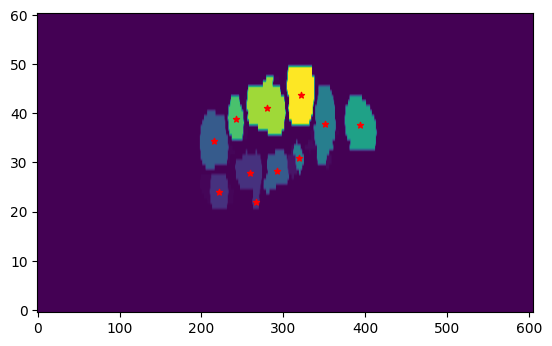

In [22]:
from armscan_env.clustering import (
    TissueClusters,
    TissueLabel,
    find_DBSCAN_clusters,
)

clusters_680 = TissueClusters(
    bones=find_DBSCAN_clusters(
        TissueLabel.BONES,
        mri_1_label_data[:, 680, :],
        eps=4.1,
        min_samples=46,
    ),
    tendons=find_DBSCAN_clusters(
        TissueLabel.TENDONS,
        mri_1_label_data[:, 680, :],
        eps=3.0,
        min_samples=18,
    ),
    ulnar=find_DBSCAN_clusters(
        TissueLabel.ULNAR,
        mri_1_label_data[:, 680, :],
        eps=2.0,
        min_samples=10,
    ),
)

show_clusters(clusters_680, mri_1_label_data[:, 680, :])
plt.show()

In [23]:
sweep_loss = []
zero_loss_clusters = []

for i in range(mri_1_label_data.shape[1]):
    clusters = TissueClusters(
        bones=find_DBSCAN_clusters(
            TissueLabel.BONES,
            mri_1_label_data[:, i, :],
            eps=4.1,
            min_samples=46,
        ),
        tendons=find_DBSCAN_clusters(
            TissueLabel.TENDONS,
            mri_1_label_data[:, i, :],
            eps=3.0,
            min_samples=18,
        ),
        ulnar=find_DBSCAN_clusters(
            TissueLabel.ULNAR,
            mri_1_label_data[:, i, :],
            eps=2.0,
            min_samples=10,
        ),
    )
    loss = anatomy_based_rwd(clusters, n_landmarks=[7, 3, 1])
    if loss == 0:
        zero_loss_clusters.append(clusters)
    print(f"Loss for slice {i}: {loss}")
    sweep_loss.append(loss)

Loss for slice 0: 1.0333333333333332
Loss for slice 1: 1.0333333333333332
Loss for slice 2: 1.0333333333333332
Loss for slice 3: 1.0333333333333332
Loss for slice 4: 1.0333333333333332
Loss for slice 5: 1.0333333333333332
Loss for slice 6: 1.0333333333333332
Loss for slice 7: 1.0333333333333332
Loss for slice 8: 1.0333333333333332
Loss for slice 9: 1.0333333333333332
Loss for slice 10: 1.0333333333333332
Loss for slice 11: 1.0333333333333332
Loss for slice 12: 1.0333333333333332
Loss for slice 13: 1.0333333333333332
Loss for slice 14: 1.0333333333333332
Loss for slice 15: 1.0333333333333332
Loss for slice 16: 1.0333333333333332
Loss for slice 17: 1.0333333333333332
Loss for slice 18: 1.0333333333333332
Loss for slice 19: 1.0333333333333332
Loss for slice 20: 1.0333333333333332
Loss for slice 21: 1.0333333333333332
Loss for slice 22: 1.0333333333333332
Loss for slice 23: 1.0333333333333332
Loss for slice 24: 1.0333333333333332
Loss for slice 25: 1.0333333333333332
Loss for slice 26: 1.0

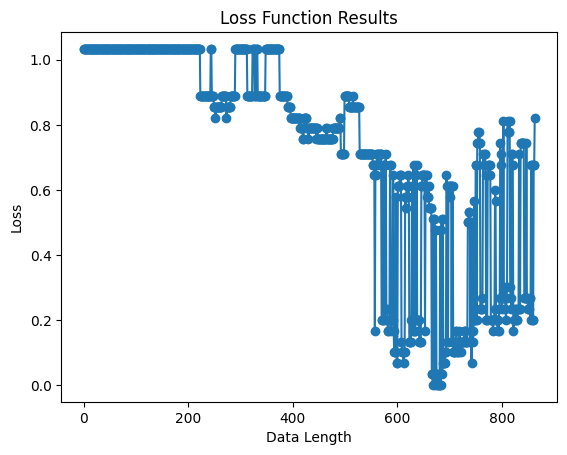

In [24]:
# Plot the loss results over the length of the data
plt.plot(range(len(sweep_loss)), sweep_loss, marker="o")

# Add labels and title
plt.xlabel("Data Length")
plt.ylabel("Loss")
plt.title("Loss Function Results")

# Show the plot
plt.show()

In general, this algorithm offers a better anatomical description, since it allows to reason about the average dimension of the clusters for each kind of tissue, removing possible outliers given by segmentation errors.

8 indices return a zero loss:  [668 673 675 677 679 680 681 683]


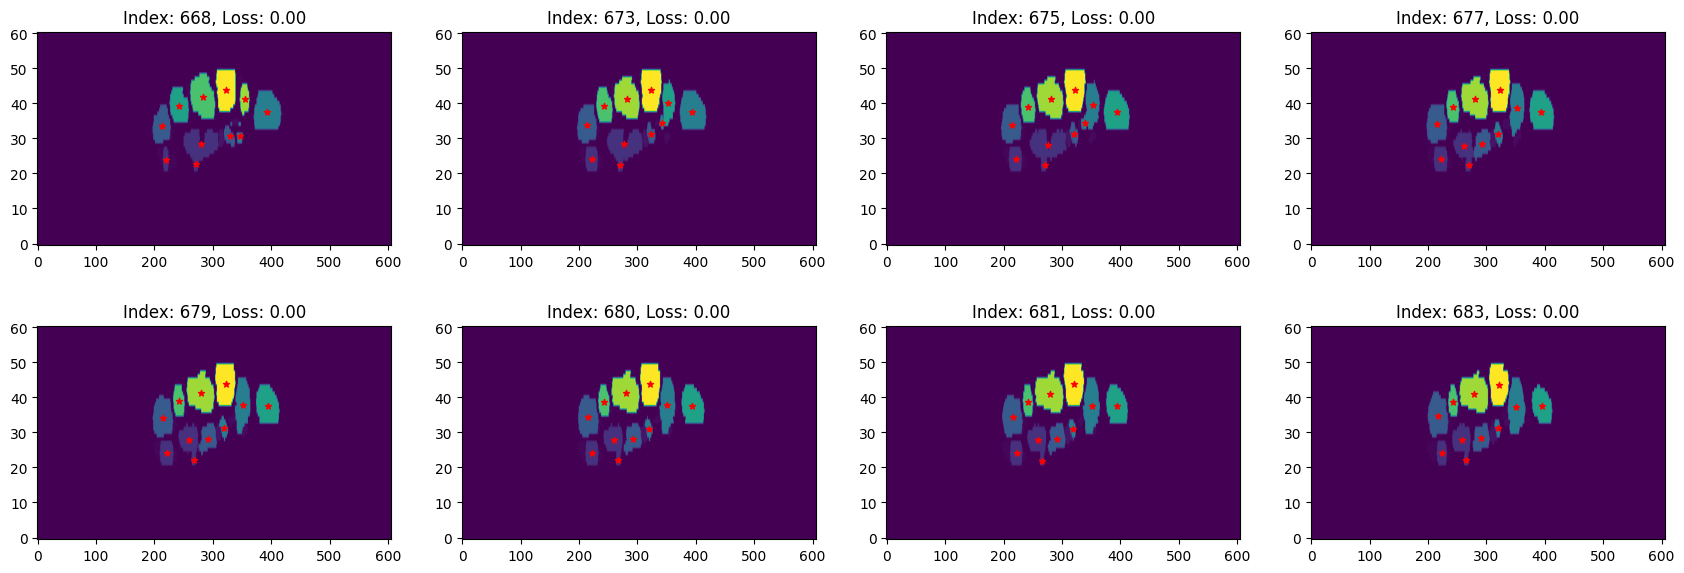

In [25]:
zero_loss_indices = np.where(np.array(sweep_loss) == 0)[0]
print(f"{len(zero_loss_indices)} indices return a zero loss: ", zero_loss_indices)

fig, axes = plt.subplots(2, 4, figsize=(21, 7))
axes = axes.flatten()
for i, idx in enumerate(zero_loss_indices):
    axes[i] = show_clusters(
        tissue_clusters=zero_loss_clusters[i],
        slice=mri_1_label_data[:, idx, :],
        ax=axes[i],
    )
    axes[i].set_title(f"Index: {idx}, Loss: {sweep_loss[idx]:.2f}")

plt.show()

You can play around with the parameter of DBSCAN to find the best tuning, or you can use the constructor `TissueClusters.from_labelmap_slice` which iterates through the tissues to find clusters with predetermined parameters `eps` and `min_samples`.

In [26]:
sweep_loss = []
zero_loss_clusters = []

for i in range(mri_1_label_data.shape[1]):
    clusters = TissueClusters.from_labelmap_slice(mri_1_label_data[:, i, :])
    loss = anatomy_based_rwd(clusters, n_landmarks=[7, 2, 1])
    if loss == 0:
        zero_loss_clusters.append(clusters)
    print(f"Loss for slice {i}: {loss}")
    sweep_loss.append(loss)

Loss for slice 0: 1.0
Loss for slice 1: 1.0
Loss for slice 2: 1.0
Loss for slice 3: 1.0
Loss for slice 4: 1.0
Loss for slice 5: 1.0
Loss for slice 6: 1.0
Loss for slice 7: 1.0
Loss for slice 8: 1.0
Loss for slice 9: 1.0
Loss for slice 10: 1.0
Loss for slice 11: 1.0
Loss for slice 12: 1.0
Loss for slice 13: 1.0
Loss for slice 14: 1.0
Loss for slice 15: 1.0
Loss for slice 16: 1.0
Loss for slice 17: 1.0
Loss for slice 18: 1.0
Loss for slice 19: 1.0
Loss for slice 20: 1.0
Loss for slice 21: 1.0
Loss for slice 22: 1.0
Loss for slice 23: 1.0
Loss for slice 24: 1.0
Loss for slice 25: 1.0
Loss for slice 26: 1.0
Loss for slice 27: 1.0
Loss for slice 28: 1.0
Loss for slice 29: 1.0
Loss for slice 30: 1.0
Loss for slice 31: 1.0
Loss for slice 32: 1.0
Loss for slice 33: 1.0
Loss for slice 34: 1.0
Loss for slice 35: 1.0
Loss for slice 36: 1.0
Loss for slice 37: 1.0
Loss for slice 38: 1.0
Loss for slice 39: 1.0
Loss for slice 40: 1.0
Loss for slice 41: 1.0
Loss for slice 42: 1.0
Loss for slice 43: 1.

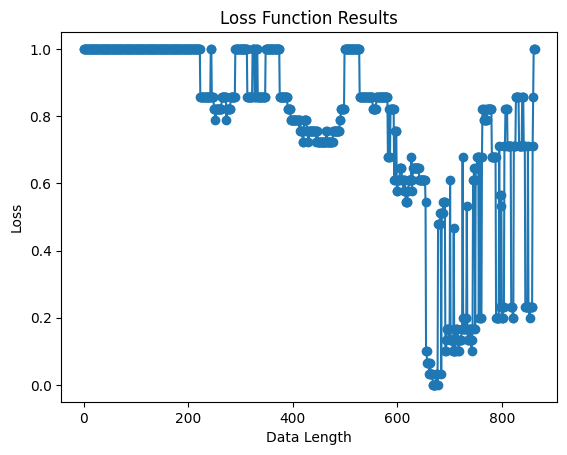

In [27]:
plt.plot(range(len(sweep_loss)), sweep_loss, marker="o")
plt.xlabel("Data Length")
plt.ylabel("Loss")
plt.title("Loss Function Results")

plt.show()

7 indices return a zero loss:  [668 669 670 671 672 673 677]


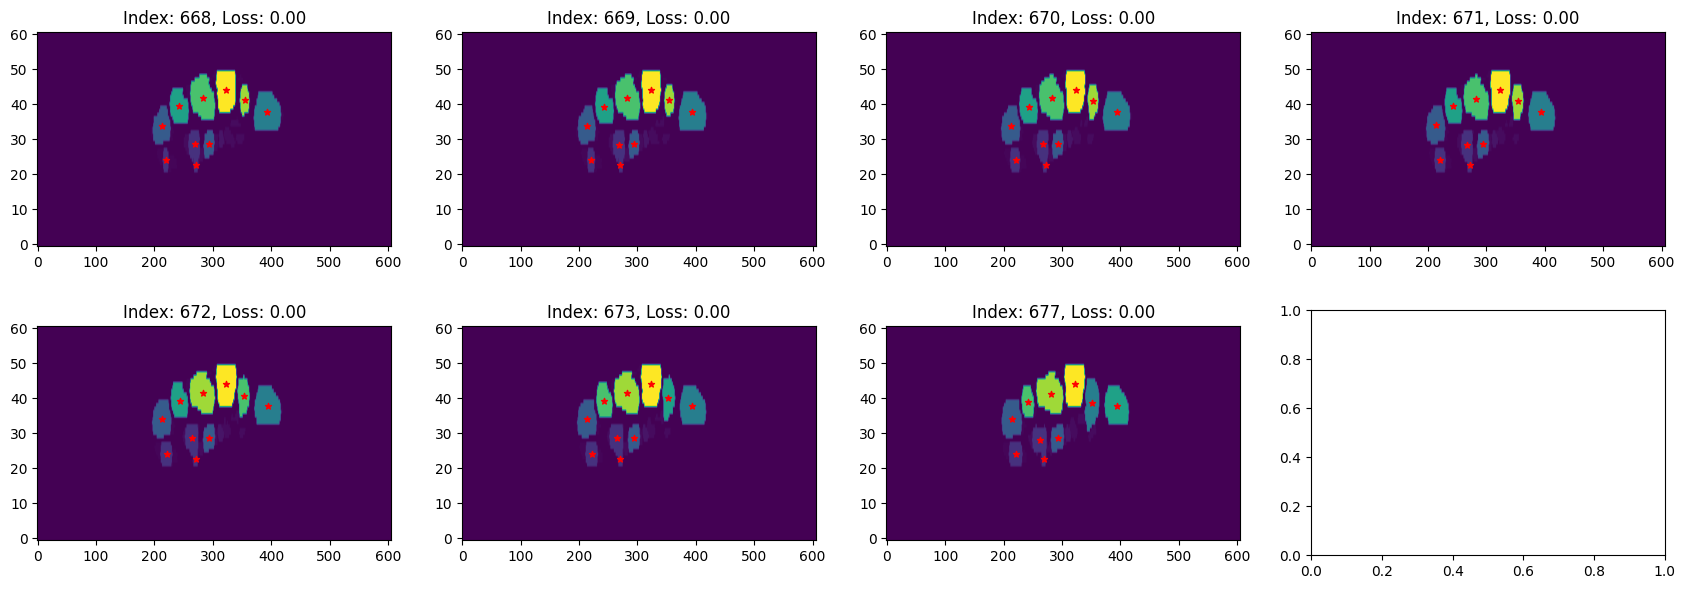

In [28]:
zero_loss_indices = np.where(np.array(sweep_loss) == 0)[0]
print(f"{len(zero_loss_indices)} indices return a zero loss: ", zero_loss_indices)

fig, axes = plt.subplots(2, 4, figsize=(21, 7))
axes = axes.flatten()
for i, idx in enumerate(zero_loss_indices):
    axes[i] = show_clusters(
        tissue_clusters=zero_loss_clusters[i],
        slice=mri_1_label_data[:, idx, :],
        ax=axes[i],
    )
    axes[i].set_title(f"Index: {idx}, Loss: {sweep_loss[idx]:.2f}")

plt.show()